<a href="https://colab.research.google.com/github/signLangProjectNIC/tf-cnn-lstm4/blob/main/TL_keras_VGG16_5_SUCCESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
model.fit_generator(epochs=2,verbose=2,generator=training_generator,
                  validation_data=validation_generator)

Shape of X output by data generator:  (10, 2, 224, 224, 3)
Epoch 1/2
Shape of X output by data generator:  (10, 2, 224, 224, 3)
Shape of X output by data generator:  (10, 2, 224, 224, 3)
Shape of X output by data generator:  (10, 2, 224, 224, 3)
3/3 - 122s - loss: 2.3219 - accuracy: 0.0000e+00
Epoch 2/2
Shape of X output by data generator:  (10, 2, 224, 224, 3)
Shape of X output by data generator:  (10, 2, 224, 224, 3)
Shape of X output by data generator:  (10, 2, 224, 224, 3)


KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import keras
import os
from PIL import Image
from matplotlib import pyplot as plt
from moviepy.editor import *
import cv2
import moviepy
import sys
import random
import tensorflow.keras.layers as tfKL
from tensorflow.keras import regularizers
from keras.layers import Activation, Dense 
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import random
import pandas as pd
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras import Sequential
from keras.layers import Dense, Concatenate, Input, Lambda,LSTM,Reshape
from keras.models import Model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3907584/45929032 bytes (8.5%)8003584/45929032 bytes (17.4%)12009472/45929032 bytes (26.1%)16138240/45929032 bytes (35.1%)20013056/45929032 bytes (43.6%)23994368/45929032 bytes (52.2%)28196864/45929032 bytes (61.4%)32284672/45929032 bytes (70.3%)36421632/45929032 bytes (79.3%)40640512/45929032 bytes (88.5%)44728320/45929032 bytes (97.4%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
mainPath="/content/gdrive/MyDrive/hand sign database"

Mounted at /content/gdrive


In [ ]:
nCategories=8

In [ ]:
partition ={}
labels ={}

In [ ]:
partition['train']=list()
partition['validation']=list()
partition['test']=list()

In [ ]:
def mapCatToNumber(file1):
  strings=[]
  for cat in os.listdir(file1):
    strings.append(cat)
  stringsS=sorted(strings)
  answer={}
  for i in range(len(stringsS)):
    answer[stringsS[i]]=i
  return answer
mappingCatToN=mapCatToNumber(mainPath)
print(mappingCatToN)

{'accident': 0, 'call': 1, 'doctor': 2, 'help': 3, 'hot': 4, 'lose': 5, 'pain': 6, 'thief': 7}


In [ ]:
for category in os.listdir(mainPath):
  print(category)
  vidL=[]
  for video in os.listdir(os.path.join(mainPath,category)):
    vidL.append(os.path.join(mainPath,category,video))
  lenVidL=len(vidL)
  trainLen=(int)(3*lenVidL/4)
  testLen=int(lenVidL/10)
  valLen=lenVidL-trainLen-testLen
  print(trainLen," ",valLen," ",testLen)
  random.shuffle(vidL)
  for i in range(lenVidL):
    labels[vidL[i]]=mappingCatToN[category]
    if i<trainLen:
      partition['train'].append(vidL[i])
    elif i<trainLen+valLen:
      partition['validation'].append(vidL[i])
    else:
      partition['test'].append(vidL[i])

hot
39   8   5
call
39   8   5
lose
30   6   4
pain
39   8   5
doctor
39   8   5
accident
39   8   5
thief
37   8   5
help
39   8   5


In [ ]:
print(np.shape(partition['train']))
print(np.shape(partition['validation']))
print(np.shape(partition['test']))

(301,)
(62,)
(39,)


In [ ]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, list_IDs, labels, batch_size=32, dim=(20,224,224,3), n_classes=8, shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      # Store sample
      # X[i,] = np.load('data/' + ID + '.npy')
      ######
      # print(ID)
      try:
        vidObj = moviepy.editor.VideoFileClip(ID)
      except IOError as e:
        errno, strerror = e.args
        print(errno)
        print(strerror)
      video_duration = int(vidObj.duration)   
      nFrames=self.dim[0]
      array=np.empty(shape=(nFrames,224,224,3))
      frameSize=(self.dim[1],self.dim[2])
      for k in range(nFrames):
        frame=vidObj.get_frame((k+1)*video_duration/(nFrames*1.0))
        frameR=Image.fromarray(frame).convert("RGB")
        frame2=frameR.resize(frameSize)
        arrayi=np.array(frame2)/255
        # if k is 0:
        #   print(np.shape(arrayi))
        array[k]=arrayi
      # print(np.shape(array))
      X[i,]=array
      #######
      # Store class
      y[i] = self.labels[ID]
    print("Shape of X output by data generator: ",np.shape(X))
    return np.array(X), keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
def createModel4(Tframes=20,batch_size=10,epochs=500,verbose=2,metrics=['accuracy'],loss='categorical_crossentropy',optimizer='adam'):
  input=Input(shape=(Tframes,224,224,3))
  branchOutputs=[]
  for i in range(Tframes):
    out=Lambda(lambda x: x[:,i,:,:,:])(input)
    print("out.shape: ",out.shape)
    name="vgg16_"+str(i)
    tempModel=Sequential(name=name)
    tempModel.add(VGG16(include_top=False,input_shape=(224,224,3)))
    out1=tempModel(out)
    branchOutputs.append(out1)
  out = Concatenate()(branchOutputs)
  model=Model(inputs=input,outputs=out)
  model2=Sequential()
  model2.add(model)
  model2.add(tfKL.TimeDistributed(LSTM(units=147,activation='tanh',input_shape=(None,7,7,512))))
  model2.add(tfKL.Flatten())
  model2.add(Dense(units=8,activation='softmax'))
  model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model2

In [ ]:
#this means it works!!!

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
with tf.device('/device:GPU:0'):
  Tframes=10
  batch_size=10
  params = {'dim': (Tframes,224,224,3),
            'batch_size': batch_size,
            'n_classes': 8,
            'shuffle': True}

  # Generators
  training_generator = DataGenerator(partition['train'], labels, **params)
  validation_generator = DataGenerator(partition['validation'], labels, **params)


  model=createModel4(Tframes=Tframes)
  history=model.fit_generator(epochs=2,verbose=2,generator=training_generator,
                    validation_data=validation_generator)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Epoch 1/2
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X

In [ ]:
#this simply means that we will need too much computational power

In [ ]:
import time

out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by data generator:  (10, 10, 224, 224, 3)
Shape of X output by

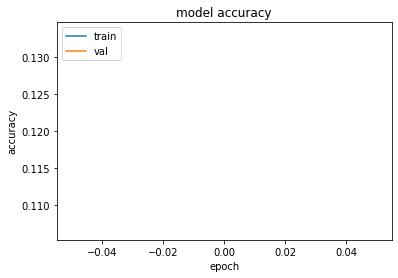

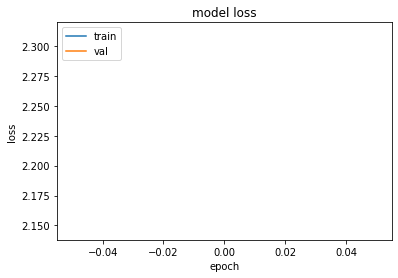

In [ ]:
with tf.device('/device:GPU:0'):
  Tframes=10
  batch_size=10
  params = {'dim': (Tframes,224,224,3),
            'batch_size': batch_size,
            'n_classes': 8,
            'shuffle': True}

  # Generators
  training_generator = DataGenerator(partition['train'], labels, **params)
  validation_generator = DataGenerator(partition['validation'], labels, **params)


  model=createModel4(Tframes=Tframes)
  history=model.fit_generator(epochs=1,verbose=2,generator=training_generator,
                    validation_data=validation_generator)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
out.shape:  (None, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Epoch 1/10
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape of X output by data generator:  (10, 12, 224, 224, 3)
Shape

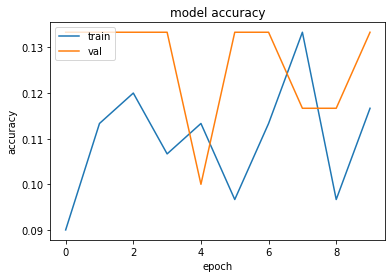

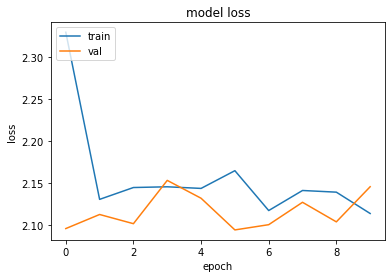

Time taken:  1962.631662607193


In [ ]:
with tf.device('/device:GPU:0'):
  Tframes=12
  batch_size=10
  params = {'dim': (Tframes,224,224,3),
            'batch_size': batch_size,
            'n_classes': 8,
            'shuffle': True}

  # Generators
  training_generator = DataGenerator(partition['train'], labels, **params)
  validation_generator = DataGenerator(partition['validation'], labels, **params)


  model=createModel4(Tframes=Tframes)
  begin=time.time()
  history=model.fit_generator(epochs=10,verbose=2,generator=training_generator,
                    validation_data=validation_generator)
  end=time.time()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  print("Time taken: ",end-begin)